In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import PIL
import tensorflow as tf
import seaborn as sns
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
print(tf.__version__)

2.19.0


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


Mouting Drive to access the dataset

In [ ]:
from google.colab import drive
import pathlib

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data_dir = "/content/drive/MyDrive/noiseless_CST64_dataset/Train_noiseless_CST64"
train_data_dir = pathlib.Path(train_data_dir)

training_image_count = len(list(train_data_dir.glob('*/*.jpg')))
print(f"{training_image_count} training images in noiseless CST64.")

12029 training images in noiseless CST64.


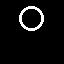

In [ ]:
circle = list(train_data_dir.glob('circle/*'))
PIL.Image.open(str(circle[310]))

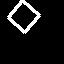

In [ ]:
square = list(train_data_dir.glob('square/*'))
PIL.Image.open(str(square[124]))

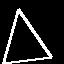

In [ ]:
triangle = list(train_data_dir.glob('triangle/*'))
PIL.Image.open(str(triangle[767]))

In [ ]:
## These hyper-parameters are NOT necessary OPTIMAL
## ECEN 250 students are free to reconfigure these values

batch_size = 32
lr = 0.0005
img_height = 64
img_width = 64
seed = 123
epochs = 20

In [ ]:
# Load training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.1,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=True
)

Found 12029 files belonging to 3 classes.
Using 10827 files for training.


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.1,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=True
)

Found 12029 files belonging to 3 classes.
Using 1202 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

## We reshape from (64, 64, 1) to (64, 64)
train_ds = train_ds.map(lambda x, y: (tf.squeeze(x, axis=-1), y))
val_ds = val_ds.map(lambda x, y: (tf.squeeze(x, axis=-1), y))

['circle', 'square', 'triangle']


In [ ]:
# Normalize and Prefetch
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

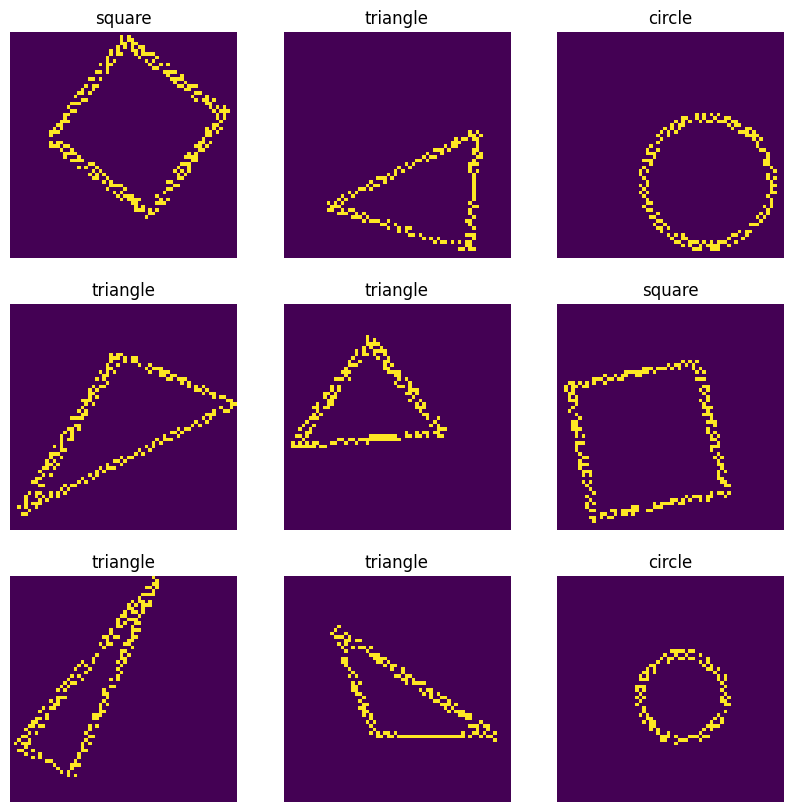

In [ ]:
## train_ds.take(4) reads one bacth from the dataset, it's batch number 4

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(4): ## The labels from the dataset are integers
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64)
(32,)


In [ ]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 2, 1, 1, 1, 1, 0, 0, 1, 0, 0, 2, 1, 1, 1, 2, 0, 0, 0, 0, 2, 1,
       0, 1, 1, 0, 1, 1, 2, 2, 1, 1], dtype=int32)>

In [ ]:
len(train_ds)   ## it will give the size of the data set in batches

339

In [ ]:
num_classes = len(class_names)


model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(img_height, img_width)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=loss_fn,
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_20 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,909,315 (18.73 MB)

 Trainable params: 4,909,315 (18.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback_earlystop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
callback_reduceLR = tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

history = model.fit(
    train_ds,
    epochs=50,
    callbacks=[callback_earlystop, callback_reduceLR]
)

Epoch 1/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.3602 - loss: 1.1065 - learning_rate: 5.0000e-04
Epoch 2/50
 36/339 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5299 - loss: 0.8381

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5902 - loss: 0.7728 - learning_rate: 5.0000e-04
Epoch 3/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7224 - loss: 0.5451 - learning_rate: 5.0000e-04
Epoch 4/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8142 - loss: 0.4213 - learning_rate: 5.0000e-04
Epoch 5/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8789 - loss: 0.3110 - learning_rate: 5.0000e-04
Epoch 6/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9213 - loss: 0.2230 - learning_rate: 5.0000e-04
Epoch 7/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9397 - loss: 0.1709 - learning_rate: 5.0000e-04
Epoch 8/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9507 - loss: 0.1413 - learning_rate: 5.0000e-04
Epoch 9/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9626 - loss: 0.1155 - learning_rate: 5.0000e-04
Epoch 10/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9706 - loss: 0.0914 - learning_r

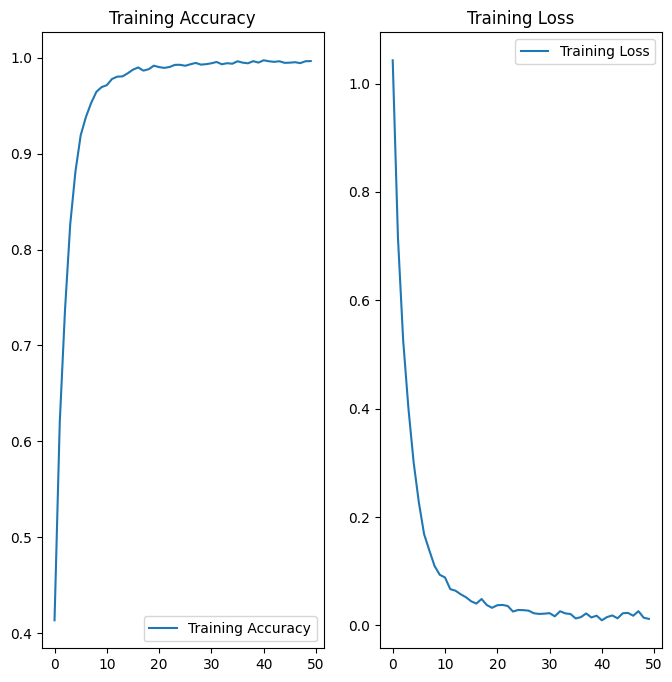

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(len(acc))  # Automatically match the number of epochs trained

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.show()

In [ ]:
test_data_dir="/content/drive/MyDrive/noiseless_CST64_dataset/Test_noiseless_CST64"
test_data_dir = pathlib.Path(test_data_dir)
test_image_count = len(list(test_data_dir.glob('*/*.jpg')))
print(f"%d training images in noiseless CST64." % (test_image_count))

1200 training images in noiseless CST64.


(64, 64)


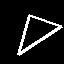

In [ ]:
### Try a noiseless triangle
image_name="/content/drive/MyDrive/noiseless_CST64_dataset/Test_noiseless_CST64/triangle/synthetic_triangle_test_4043.jpg"

im=PIL.Image.open(image_name)
old_size=im.size
new_size=im.size
if old_size != (img_width,img_height):
     ratio = float(img_width)/max(old_size)
     new_size = tuple([int(x*ratio) for x in old_size])
     im = im.resize(new_size, PIL.Image.Resampling.LANCZOS)  ## Image.ANTIALIAS
     ##new_im = PIL.Image.new("RGB", (img_width, img_height))
     new_im = PIL.Image.new("L", (img_width, img_height))
     new_im.paste(im, ((img_width-new_size[0])//2, (img_height-new_size[1])//2))
else:
     new_im=im

print(new_size)
display(new_im)

In [ ]:
### Ask the model about this image

img_array = tf.keras.utils.img_to_array(new_im)
img_array = tf.expand_dims(img_array, 0) # Create a batch
print(img_array.shape)
predictions = model.predict(img_array)
score = predictions[0]   ## no need for softmax(), but it is activated in this model
print(score)
winning_class = np.argmax(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[winning_class], 100 * np.max(score))
)

(1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0. 0. 1.]
This image most likely belongs to triangle with a 100.00 percent confidence.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  validation_split=0, ## no validation
  seed=123,
  image_size=(img_height, img_width), ## You can resize all input images
  color_mode="grayscale", ## "rgb" for color images
  batch_size=batch_size,
  shuffle=True)

Found 1200 files belonging to 3 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    image_size=(img_height, img_width),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=False
)

Found 1200 files belonging to 3 classes.


In [ ]:
test_ds = test_ds.map(lambda x, y: (tf.squeeze(x, axis=-1), y))

test_ds = test_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy:.2f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9561 - loss: 0.3446
Test Loss: 0.3810923099517822
Test Accuracy: 0.95
